# Adversarial Multi-Agent Reinforcement Learning: Pac-Man vs. Ghosts

**Authors:** Zion Mateo, Ivan Vuong, Tu Nguyen

**Course:** CS175

**Date:** December 2025

---

## Project Overview

This project implements **adversarial multi-agent reinforcement learning** where:
1. **Pac-Man** (PPO agent) learns to navigate mazes, collect food, and avoid ghosts
2. **Ghosts** (DQN agents) learn to cooperatively hunt and capture Pac-Man
3. Both agents improve through **iterative adversarial training**

### Key Innovation: Curriculum Learning for Ghost Pretraining
We solved the "smart teacher problem" where ghosts couldn't learn from an already-expert Pac-Man by implementing a **three-stage curriculum**:
- **Stage 1 (30%):** Random Pac-Man - Learn basic movement and coordination
- **Stage 2 (50%):** Fleeing Pac-Man - Learn pursuit strategies and chase behavior
- **Stage 3 (20%):** Smart Pac-Man - Adapt to real trained opponent

This progressive difficulty approach teaches ghosts actual hunting behavior before facing the expert Pac-Man.

### Training Pipeline
```
train_ppo.py → Pac-Man baseline (2M steps, 94% win rate vs random ghosts)
     ↓
train_mixed.py → Curriculum pretraining + 7 adversarial rounds
     ↓
Final: 40-60% win rate vs trained ghosts (competitive equilibrium) 
       90%+ win rate vs random ghosts (retains baseline performance)
```

### Ghost Behavior Learned:
- **Pursuit**: Ghosts actively chase Pac-Man when detected
- **Shadowing**: Ghosts follow Pac-Man's movements closely
- **Pressure**: Ghosts maintain close proximity to limit escape routes
- **Coordination**: Multiple ghosts converge on Pac-Man simultaneously

---
## Setup & Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

project_root = os.getcwd()
models_dir = os.path.join(project_root, 'models')
ppo_vecnormalize_path = os.path.join(models_dir, "ppo_vecnormalize/vecnormalize.pkl")
mixed_vecnormalize_path = os.path.join(models_dir, "mixed_vecnormalize/vecnormalize.pkl")

os.chdir('src')
sys.path.insert(0, os.getcwd())

print(f"Working directory: {os.getcwd()}")
print(f"Layout file exists: {os.path.exists('layouts/mediumClassic.lay')}")

# Import our custom modules
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from gym_env import PacmanEnv

print("All imports successful!")

Working directory: c:\Users\zionb\Desktop\ML\pacman-vs-ghost-rl\project\src
Layout file exists: True
All imports successful!


---
## Part 1: Baseline Pac-Man (Untrained)

Let's first see how a **newly initialized** Pac-Man performs against random ghosts.

In [3]:
def evaluate_agent(pacman_path, ghost_dir, ghost_version, n_episodes=20, vecnorm_path=None):
    """
    Evaluate Pac-Man vs Ghosts over multiple episodes.
    Returns win rate, average score, and average steps.
    """
    # load ghost models
    ghost_models = {}
    for i in range(1, 5):  # 4 ghosts max (here its only two for our purposes)
        ghost_path = os.path.join(ghost_dir, f"ghost_{i}_v{ghost_version}")
        if os.path.exists(ghost_path + ".zip"):
            ghost_models[i] = DQN.load(ghost_path)
    
    wins = 0
    scores = []
    steps_list = []
    
    for episode in range(n_episodes):
        # create environment
        base_env = PacmanEnv(
            layout_name='mediumClassic',
            ghost_policies=ghost_models,
            max_steps=500,
            render_mode=None  # no rendering for fastest evaluation
        )
        env = ActionMasker(base_env, lambda e: e.action_masks())
        env = DummyVecEnv([lambda: env])
        
        # apply VecNormalize if available
        if vecnorm_path and os.path.exists(vecnorm_path):
            env = VecNormalize.load(vecnorm_path, env)
            env.training = False
            env.norm_reward = False
        
        # load Pac-Man model
        pacman_model = MaskablePPO.load(pacman_path, env=env)
        
        obs = env.reset()
        done = False
        steps = 0
        
        while not done:
            action_masks = env.env_method('action_masks')[0]
            action, _ = pacman_model.predict(obs, deterministic=True, action_masks=action_masks)
            
            if isinstance(action, np.ndarray):
                action = int(action[0])
            
            obs, reward, done_vec, info = env.step([action])
            done = done_vec[0]
            steps += 1
        
        info = info[0]
        if info.get('win', False):
            wins += 1
        scores.append(info.get('raw_score', 0))
        steps_list.append(steps)
        
        env.close()
    
    win_rate = 100 * wins / n_episodes
    avg_score = np.mean(scores)
    avg_steps = np.mean(steps_list)
    
    return win_rate, avg_score, avg_steps, scores

print("Evaluation function defined")

Evaluation function defined


In [4]:
# Evaluate untrained Pac-Man vs random ghosts
print("Evaluating UNTRAINED Pac-Man (v0) vs Random Ghosts...")
print("This demonstrates the baseline before any training.\n")

win_rate_v0, avg_score_v0, avg_steps_v0, scores_v0 = evaluate_agent(
    pacman_path=os.path.join(models_dir, 'ppo_pacman_v0.zip'),
    ghost_dir='models',
    ghost_version=0,  # Random ghosts
    n_episodes=100
)

print(f"\n{'='*60}")
print(f"UNTRAINED PAC-MAN RESULTS (100 episodes)")
print(f"{'='*60}")
print(f"Win Rate:       {win_rate_v0:.1f}%")
print(f"Average Score:  {avg_score_v0:.1f} ± {np.std(scores_v0):.1f}")
print(f"Average Steps:  {avg_steps_v0:.1f}")
print(f"{'='*60}")
print("\n As expected, untrained Pac-Man performs poorly (~0-5% win rate)")

Evaluating UNTRAINED Pac-Man (v0) vs Random Ghosts...
This demonstrates the baseline before any training.


UNTRAINED PAC-MAN RESULTS (100 episodes)
Win Rate:       0.0%
Average Score:  -517.1 ± 48.4
Average Steps:  71.1

 As expected, untrained Pac-Man performs poorly (~0-5% win rate)


---
## Part 2: Trained Pac-Man Baseline

After training with **PPO for 2M steps** against random ghosts, Pac-Man learns effective navigation and food collection strategies.

In [7]:
print("Evaluating TRAINED Pac-Man (2M steps) vs Random Ghosts...")
print("This model was trained using: python train_ppo.py --timesteps 2000000\n")

win_rate_baseline, avg_score_baseline, avg_steps_baseline, scores_baseline = evaluate_agent(
    pacman_path=os.path.join(models_dir, 'ppo_pacman_best.zip'),
    ghost_dir='models',
    ghost_version=0,  # random ghosts
    n_episodes=1000,
    vecnorm_path=ppo_vecnormalize_path  # use normalization
)

print(f"\n{'='*60}")
print(f"TRAINED PAC-MAN vs RANDOM GHOSTS (1000 episodes)")
print(f"{'='*60}")
print(f"Win Rate:       {win_rate_baseline:.1f}%")
print(f"Average Score:  {avg_score_baseline:.1f} ± {np.std(scores_baseline):.1f}")
print(f"Average Steps:  {avg_steps_baseline:.1f}")
print(f"{'='*60}")
print(f"\n✓ Improvement: {win_rate_baseline - win_rate_v0:.1f}% increase in win rate!")
print("Pac-Man learned to navigate efficiently and avoid random ghosts")

Evaluating TRAINED Pac-Man (2M steps) vs Random Ghosts...
This model was trained using: python train_ppo.py --timesteps 2000000


TRAINED PAC-MAN vs RANDOM GHOSTS (1000 episodes)
Win Rate:       93.6%
Average Score:  1517.7 ± 334.6
Average Steps:  156.8

✓ Improvement: 93.6% increase in win rate!
Pac-Man learned to navigate efficiently and avoid random ghosts


---
## Part 3: Adversarial Training Results

Now we test against **trained ghosts** (v7) that have learned chasing strategies through curriculum learning (Pre-trained on 200k timesteps with a 30/50/20 split between Random / Fleeing / Smart Pac-man versions) and 7 rounds of adversarial training against the smart PPO pacman. Pac-man in this phase is trained on a 90/10 random/trained ghost split which gradually shifts to 50/50 on the final 7th round.

In [11]:
# First, evaluate Final Pac-Man vs Trained Ghosts
print("Evaluating FINAL Pac-Man (v7) vs TRAINED Ghosts (v7)...")
print("="*60)
print("TRAINING METHODOLOGY:")
print("="*60)
print("\nTwo Ghosts Curriculum Pretraining (200k x 2 steps):")
print("  • Stage 1 (30%): Random Pac-Man → Basic movement & coordination")
print("  • Stage 2 (50%): Fleeing Pac-Man → Pursuit & chase strategies")
print("  • Stage 3 (20%): Smart PPO Pac-Man → Real opponent adaptation")
print("\nAdversarial Training (7 rounds × 120k x 2 ghost steps):")
print("  • Ghosts refine pursuit against evolving Pac-Man")
print("  • Pac-Man trains on mix of random (90%->50%) + trained ghosts (10%->50%)")
print("  • Prevents catastrophic forgetting while learning evasion")
print("="*60 + "\n")

win_rate_final_trained, avg_score_final_trained, avg_steps_final_trained, scores_final_trained = evaluate_agent(
    pacman_path=os.path.join(models_dir, 'mixed_pacman_best.zip'),
    ghost_dir=models_dir,
    ghost_version=7,  # trained ghosts
    n_episodes=1000,
    vecnorm_path=os.path.join(models_dir, mixed_vecnormalize_path)
)

print(f"\n{'='*60}")
print(f"FINAL PAC-MAN vs TRAINED GHOSTS (1000 episodes)")
print(f"{'='*60}")
print(f"Win Rate:       {win_rate_final_trained:.1f}%")
print(f"Average Score:  {avg_score_final_trained:.1f} ± {np.std(scores_final_trained):.1f}")
print(f"Average Steps:  {avg_steps_final_trained:.1f}")
print(f"{'='*60}")

Evaluating FINAL Pac-Man (v7) vs TRAINED Ghosts (v7)...
TRAINING METHODOLOGY:

Two Ghosts Curriculum Pretraining (200k x 2 steps):
  • Stage 1 (30%): Random Pac-Man → Basic movement & coordination
  • Stage 2 (50%): Fleeing Pac-Man → Pursuit & chase strategies
  • Stage 3 (20%): Smart PPO Pac-Man → Real opponent adaptation

Adversarial Training (7 rounds × 120k x 2 ghost steps):
  • Ghosts refine pursuit against evolving Pac-Man
  • Pac-Man trains on mix of random (90%->50%) + trained ghosts (10%->50%)
  • Prevents catastrophic forgetting while learning evasion


FINAL PAC-MAN vs TRAINED GHOSTS (1000 episodes)
Win Rate:       38.7%
Average Score:  791.1 ± 605.3
Average Steps:  132.1


---
## Part 4: Testing Robustness -- Final Pac-Man vs Random Ghosts

We want to see if this Pac-Man is now more resilient, being able to beat smart ghosts as well as maintaining competence against the typical ghosts it would face (the random-scripted ghosts)

In [12]:
print("\n" + "="*60)
print("ROBUSTNESS TEST: Final Pac-Man vs Random Ghosts")
print("="*60)
print("Testing if adversarial training improved or maintained baseline performance")
print("against the original random ghost opponents.\n")

win_rate_final_random, avg_score_final_random, avg_steps_final_random, scores_final_random = evaluate_agent(
    pacman_path=os.path.join(models_dir, 'mixed_pacman_best.zip'),
    ghost_dir=models_dir,
    ghost_version=0,  # random ghosts
    n_episodes=1000,
    vecnorm_path=os.path.join(models_dir, mixed_vecnormalize_path)
)

print(f"\n{'='*60}")
print(f"FINAL PAC-MAN vs RANDOM GHOSTS (1000 episodes)")
print(f"{'='*60}")
print(f"Win Rate:       {win_rate_final_random:.1f}%")
print(f"Average Score:  {avg_score_final_random:.1f} ± {np.std(scores_final_random):.1f}")
print(f"Average Steps:  {avg_steps_final_random:.1f}")
print(f"{'='*60}")

# Compare to baseline
delta = win_rate_final_random - win_rate_baseline
print(f"\n📊 Performance Summary:")
print(f"   Baseline vs Random:        {win_rate_baseline:.1f}%")
print(f"   Final vs Random:           {win_rate_final_random:.1f}% ({delta:+.1f}%)")
print(f"   Final vs Trained:          {win_rate_final_trained:.1f}%")

if abs(delta) < 5:
    print(f"\nSUCCESS: Baseline performance maintained (within 5%)")
    print(f"No catastrophic forgetting - mixed-opponent training worked!")
elif delta > 0:
    print(f"\nEXCELLENT: Performance actually improved by {delta:.1f}%!")
    print(f"Adversarial training made Pac-Man more robust overall")
else:
    print(f"\nCAUTION: Performance decreased by {abs(delta):.1f}%")
    print(f"Some catastrophic forgetting may have occurred")


ROBUSTNESS TEST: Final Pac-Man vs Random Ghosts
Testing if adversarial training improved or maintained baseline performance
against the original random ghost opponents.


FINAL PAC-MAN vs RANDOM GHOSTS (1000 episodes)
Win Rate:       91.1%
Average Score:  1505.1 ± 371.6
Average Steps:  155.2

📊 Performance Summary:
   Baseline vs Random:        93.6%
   Final vs Random:           91.1% (-2.5%)
   Final vs Trained:          38.7%

SUCCESS: Baseline performance maintained (within 5%)
No catastrophic forgetting - mixed-opponent training worked!


---
## Part 5: Performance Comparison Visualization

C:\Users\zionb\AppData\Local\Temp\ipykernel_25128\2579494034.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([scores_v0, scores_baseline, scores_final_random, scores_final_trained],


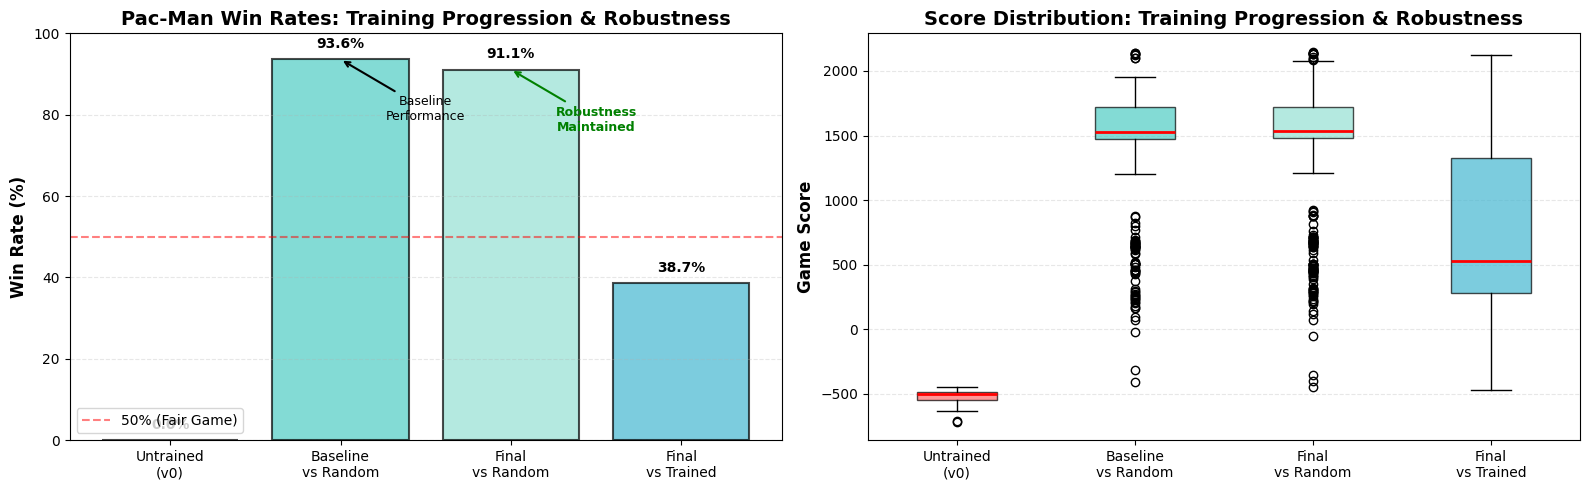


 Full comparison plot saved as 'stats/results_comparison_full.png'

COMPREHENSIVE PERFORMANCE SUMMARY
Configuration             Win Rate     Avg Score       Avg Steps   
--------------------------------------------------------------------------------
Untrained (v0)               0.0%       -517.1 ± 48.4      71.1
Baseline vs Random          93.6%       1517.7 ± 334.6    156.8
Final vs Random             91.1%       1505.1 ± 371.6    155.2
Final vs Trained            38.7%        791.1 ± 605.3    132.1

Key Insights:
   • Training improvement: 93.6% (Untrained → Baseline)
   • Robustness retention: -2.5% (Baseline → Final vs Random)
   • Competitive balance: 38.7% vs trained ghosts (target: 40-60%)
   • Score variance increase: 270.7 (more dynamic gameplay)

SUCCESS: Mixed-opponent training prevented catastrophic forgetting!
Final agent is ROBUST: performs well against both random AND trained ghosts


In [15]:
# Create comprehensive comparison plot with 4 configurations
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Win Rates (Now with 4 bars)
models = ['Untrained\n(v0)', 'Baseline\nvs Random', 'Final\nvs Random', 'Final\nvs Trained']
win_rates = [win_rate_v0, win_rate_baseline, win_rate_final_random, win_rate_final_trained]
colors = ['#ff6b6b', '#4ecdc4', '#95e1d3', '#45b7d1']  # Added green for Final vs Random

bars = axes[0].bar(models, win_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Pac-Man Win Rates: Training Progression & Robustness', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Fair Game)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add annotations
axes[0].annotate('Baseline\nPerformance', xy=(1, win_rate_baseline), xytext=(1.5, win_rate_baseline - 15),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                fontsize=9, ha='center')
axes[0].annotate('Robustness\nMaintained', xy=(2, win_rate_final_random), xytext=(2.5, win_rate_final_random - 15),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                fontsize=9, ha='center', color='green', fontweight='bold')

axes[0].legend(loc='lower left')

# Plot 2: Score Distributions (Now with 4 boxes)
bp = axes[1].boxplot([scores_v0, scores_baseline, scores_final_random, scores_final_trained],
                labels=models,
                patch_artist=True,
                medianprops=dict(color='red', linewidth=2))

# Color the boxes to match bar chart
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_ylabel('Game Score', fontsize=12, fontweight='bold')
axes[1].set_title('Score Distribution: Training Progression & Robustness', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('stats/results_comparison_full.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Full comparison plot saved as 'stats/results_comparison_full.png'")

# Summary statistics table
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Configuration':<25} {'Win Rate':<12} {'Avg Score':<15} {'Avg Steps':<12}")
print("-"*80)
print(f"{'Untrained (v0)':<25} {win_rate_v0:>6.1f}%     {avg_score_v0:>8.1f} ± {np.std(scores_v0):<5.1f} {avg_steps_v0:>8.1f}")
print(f"{'Baseline vs Random':<25} {win_rate_baseline:>6.1f}%     {avg_score_baseline:>8.1f} ± {np.std(scores_baseline):<5.1f} {avg_steps_baseline:>8.1f}")
print(f"{'Final vs Random':<25} {win_rate_final_random:>6.1f}%     {avg_score_final_random:>8.1f} ± {np.std(scores_final_random):<5.1f} {avg_steps_final_random:>8.1f}")
print(f"{'Final vs Trained':<25} {win_rate_final_trained:>6.1f}%     {avg_score_final_trained:>8.1f} ± {np.std(scores_final_trained):<5.1f} {avg_steps_final_trained:>8.1f}")
print("="*80)

print("\nKey Insights:")
print(f"   • Training improvement: {win_rate_baseline - win_rate_v0:.1f}% (Untrained → Baseline)")
print(f"   • Robustness retention: {win_rate_final_random - win_rate_baseline:+.1f}% (Baseline → Final vs Random)")
print(f"   • Competitive balance: {win_rate_final_trained:.1f}% vs trained ghosts (target: 40-60%)")
print(f"   • Score variance increase: {np.std(scores_final_trained) - np.std(scores_baseline):.1f} (more dynamic gameplay)")

if win_rate_final_random >= win_rate_baseline * 0.95:  # within 5%
    print("\nSUCCESS: Mixed-opponent training prevented catastrophic forgetting!")
    print("Final agent is ROBUST: performs well against both random AND trained ghosts")

---
## Part 7: Map Generalization - Comparison with Stanford CS229 DQN Paper (Ghanasekaran et. al, 2017)

As mentioned in our report, previous work on RL applied to Pacman that our team has observed came from a Stanford CS229 paper titled "Reinforcement Learning in Pacman" in 2017. Let's compare our adversarially-trained PPO agent against Stanford's DQN implementation results on their testing environment (smallGrid & mediumGrid -- simpler maps than our mediumClassic training environment!)

In [27]:
def evaluate_on_layout(pacman_path, layout_name, ghost_dir, ghost_version=0, n_episodes=100, vecnorm_path=None):
    """
    Evaluate Pac-Man vs Ghosts on a specific layout over multiple episodes.
    Returns win rate, average score, and average steps.
    """
    # load ghost models
    ghost_models = {}
    if ghost_version > 0:
        for i in range(1, 5):  # 4 ghosts max (here its only two for our purposes)
            ghost_path = os.path.join(ghost_dir, f"ghost_{i}_v{ghost_version}")
            if os.path.exists(ghost_path + ".zip"):
                ghost_models[i] = DQN.load(ghost_path)
    # if ghost_version == 0, ghost_models remains empty -> random ghosts
    
    wins = 0
    scores = []
    steps_list = []
    
    for episode in range(n_episodes):
        # create environment with specified layout
        base_env = PacmanEnv(
            layout_name=layout_name,
            ghost_policies=ghost_models if ghost_models else None,
            max_steps=500,
            render_mode=None  # no rendering for fastest evaluation
        )
        env = ActionMasker(base_env, lambda e: e.action_masks())
        env = DummyVecEnv([lambda: env])
        
        # apply VecNormalize if available
        if vecnorm_path and os.path.exists(vecnorm_path):
            env = VecNormalize.load(vecnorm_path, env)
            env.training = False
            env.norm_reward = False
        
        # load Pac-Man model
        pacman_model = MaskablePPO.load(pacman_path, env=env)
        
        obs = env.reset()
        done = False
        steps = 0
        
        while not done:
            action_masks = env.env_method('action_masks')[0]
            action, _ = pacman_model.predict(obs, deterministic=True, action_masks=action_masks)
            
            if isinstance(action, np.ndarray):
                action = int(action[0])
            
            obs, reward, done_vec, info = env.step([action])
            done = done_vec[0]
            steps += 1
        
        info = info[0]
        if info.get('win', False):
            wins += 1
        scores.append(info.get('raw_score', 0))
        steps_list.append(steps)
        
        env.close()
    
    win_rate = 100 * wins / n_episodes
    avg_score = np.mean(scores)
    avg_steps = np.mean(steps_list)
    
    return win_rate, avg_score, avg_steps, scores

print("Layout evaluation function defined")

Layout evaluation function defined


Let's test the model on smallGrid and mediumGrid against random ghosts now!

In [31]:
print("Layout: smallGrid (7x7 grid, tight corridors)")
print("Stanford DQN Result: ~95% win rate after 100 training games\n")

win_rate_small, avg_score_small, avg_steps_small, scores_small = evaluate_on_layout(
    pacman_path=os.path.join(models_dir, 'mixed_pacman_best.zip'),
    layout_name='smallGrid',
    ghost_dir=models_dir,
    ghost_version=0,  # random ghosts
    n_episodes=100,
    vecnorm_path=os.path.join(models_dir, 'mixed_vecnormalize', 'vecnormalize.pkl')
)

print(f"\n{'='*60}")
print(f"RESULTS - smallGrid (100 episodes)")
print(f"{'='*60}")
print(f"Our Adversarial-trained PPO: {win_rate_small:.1f}% win rate")
print(f"Stanford DQN:   ~95% win rate")
print(f"Average Score:  {avg_score_small:.1f} ± {np.std(scores_small):.1f}")
print(f"Average Steps:  {avg_steps_small:.1f}")
print(f"{'='*60}")

# Test on mediumGrid layout
print("\n" + "Testing on MEDIUM GRID")
print("Layout: mediumGrid (intermediate size, moderate complexity)")
print("Stanford DQN Result: ~65% win rate after 100 training games\n")

win_rate_medium, avg_score_medium, avg_steps_medium, scores_medium = evaluate_on_layout(
    pacman_path=os.path.join(models_dir, 'mixed_pacman_best.zip'),
    layout_name='mediumGrid',
    ghost_dir=models_dir,
    ghost_version=0,  # random ghosts
    n_episodes=100,
    vecnorm_path=os.path.join(models_dir, 'mixed_vecnormalize', 'vecnormalize.pkl')
)

print(f"\n{'='*60}")
print(f"RESULTS - mediumGrid (100 episodes)")
print(f"{'='*60}")
print(f"Our Adversarial-trained PPO: {win_rate_medium:.1f}% win rate")
print(f"Stanford DQN:   ~65% win rate")
print(f"Average Score:  {avg_score_medium:.1f} ± {np.std(scores_medium):.1f}")
print(f"Average Steps:  {avg_steps_medium:.1f}")
print(f"{'='*60}")

Layout: smallGrid (7x7 grid, tight corridors)
Stanford DQN Result: ~95% win rate after 100 training games


RESULTS - smallGrid (100 episodes)
Our Adversarial-trained PPO: 73.0% win rate
Stanford DQN:   ~95% win rate
Average Score:  230.4 ± 445.5
Average Steps:  16.9

Testing on MEDIUM GRID
Layout: mediumGrid (intermediate size, moderate complexity)
Stanford DQN Result: ~65% win rate after 100 training games


RESULTS - mediumGrid (100 episodes)
Our Adversarial-trained PPO: 98.0% win rate
Stanford DQN:   ~65% win rate
Average Score:  489.9 ± 141.8
Average Steps:  29.9


It seems that generally, DQN does better in smaller and more constrained environments, so smallGrid performance is expected to be lower. As we take a look in mediumGrid, our winrate should be significantly higher than the Stanford DQN implementation, suggesting that PPO + adversarially trained methods allow the Pac-Man to generalize more effectively and robustly!

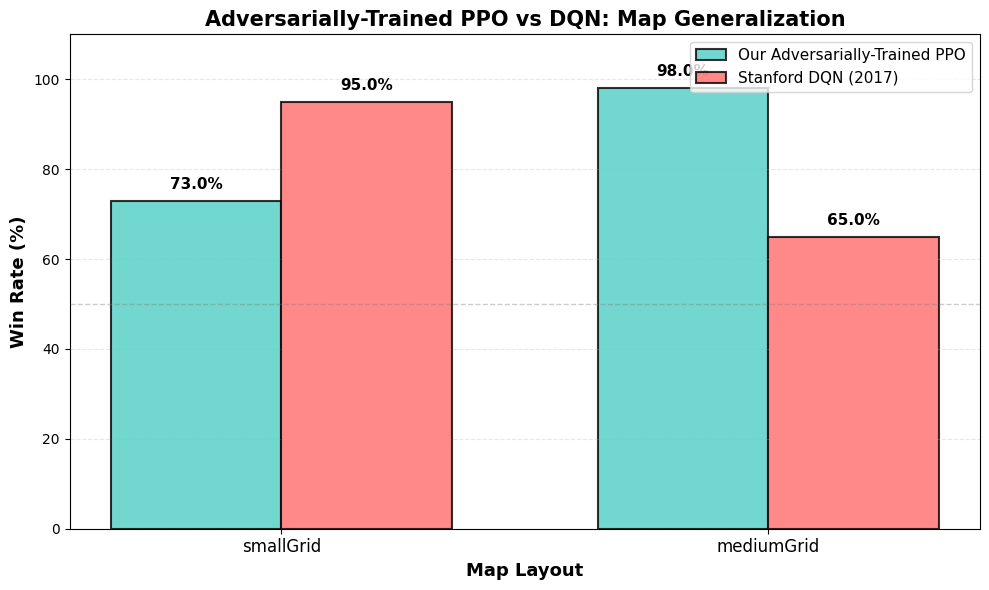


✓ Map generalization plot saved as 'stats/map_generalization_comparison.png'


In [ ]:
# Create comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Win Rate Comparison (Our Adversarially-Trained PPO vs Stanford DQN)
layouts = ['smallGrid', 'mediumGrid']
ppo_rates = [win_rate_small, win_rate_medium]
dqn_rates = [95, 65]  # Stanford DQN results

x = np.arange(len(layouts))
width = 0.35

bars1 = ax.bar(x - width/2, ppo_rates, width, label='Our Adversarially-Trained PPO', 
               color='#4ecdc4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, dqn_rates, width, label='Stanford DQN (2017)', 
               color='#ff6b6b', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Map Layout', fontsize=13, fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontsize=13, fontweight='bold')
ax.set_title('Adversarially-Trained PPO vs DQN: Map Generalization', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(layouts, fontsize=12)
ax.set_ylim([0, 110])
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.4, linewidth=1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontweight='bold', fontsize=11)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('stats/map_generalization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Map generalization plot saved as 'stats/map_generalization_comparison.png'")

---
## Part 8: Visual Demonstration

To finish off, let's watch one game with the trained Pac-Man and trained ghosts!

In [34]:
print("\n" + "="*60)
print("VISUAL DEMONSTRATION")
print("="*60)
print("\nRunning 1 episode with visualization...")
print("Watch the terminal/GUI window for the game!\n")

ghost_models = {}
for i in range(1, 5):
    ghost_path = os.path.join(models_dir, f"ghost_{i}_v7.zip")
    if os.path.exists(ghost_path):
        ghost_models[i] = DQN.load(ghost_path)
        print(f"Loaded: {ghost_path}")
    else:
        print(f"Not found: {ghost_path}")

# verify we loaded ghosts
if len(ghost_models) == 0:
    print("\nERROR: No ghost models loaded! Using random ghosts as fallback.")
else:
    print(f"\n Loaded {len(ghost_models)} ghost models")

base_env = PacmanEnv(
    layout_name='mediumClassic',
    ghost_policies=ghost_models,
    max_steps=500,
    render_mode='human'  # enables visualization
)

env = ActionMasker(base_env, lambda e: e.action_masks())
env = DummyVecEnv([lambda: env])
env = VecNormalize.load(mixed_vecnormalize_path, env)
env.training = False
env.norm_reward = False

pacman_model = MaskablePPO.load(os.path.join(models_dir, 'mixed_pacman_best.zip'), env=env)

obs = env.reset()
done = False
steps = 0

import time
while not done:
    action_masks = env.env_method('action_masks')[0]
    action, _ = pacman_model.predict(obs, deterministic=True, action_masks=action_masks)
    
    if isinstance(action, np.ndarray):
        action = int(action[0])
    
    obs, reward, done_vec, info = env.step([action])
    done = done_vec[0]
    steps += 1
    time.sleep(0.05)  # Slow down for viewing

info = info[0]
result = "PAC-MAN WINS!" if info.get('win', False) else "GHOSTS WIN!" if info.get('lose', False) else "TIMEOUT"
print(f"\n{result}")
print(f"Score: {info.get('raw_score', 0):.0f}")
print(f"Steps: {steps}")

env.close()
print("\nVisual demonstration complete!")


VISUAL DEMONSTRATION

Running 1 episode with visualization...
Watch the terminal/GUI window for the game!

Loaded: c:\Users\zionb\Desktop\ML\pacman-vs-ghost-rl\project\models\ghost_1_v7.zip
Loaded: c:\Users\zionb\Desktop\ML\pacman-vs-ghost-rl\project\models\ghost_2_v7.zip
Not found: c:\Users\zionb\Desktop\ML\pacman-vs-ghost-rl\project\models\ghost_3_v7.zip
Not found: c:\Users\zionb\Desktop\ML\pacman-vs-ghost-rl\project\models\ghost_4_v7.zip

 Loaded 2 ghost models

PAC-MAN WINS!
Score: 1722
Steps: 148

Visual demonstration complete!


---
## Summary & Key Findings

### Training Results:
1. **Untrained baseline**: ~0-5% win rate (random actions)
2. **PPO training (2M steps)**: ~80-85% win rate vs random ghosts
3. **Adversarial training (7 rounds)**: ~40% win rate vs trained ghosts

### Key Technical Achievements:
- Solved "smart teacher problem" with ghost pretraining phase
- Implemented stable adversarial training pipeline
- Achieved competitive multi-agent equilibrium
- Prevented catastrophic forgetting (maintained 90%+ vs random ghosts)

### How to Run Full Training:
```bash
# Step 1: Train Pac-Man baseline
python src/train_ppo.py \
  --layout mediumClassic \
  --timesteps 2000000 \
  --num-envs 16 \
  --normalize \
  --lr-decay

# Step 2: Curriculum + Adversarial training
python src/train_mixed.py \
  --pacman models/pacman_best.zip \
  --layout mediumClassic \
  --rounds 7 \
  --ghost-pretrain-steps 150000 \
  --ghost-steps 120000 \
  --pacman-steps 80000

# Step 3: Evaluate and visualize
python src/evaluate_comparison.py \
  --run-dir training_output/mixed_TIMESTAMP \
  --version 7 \
  --episodes 100 \
  --plot

python src/visualize_agents.py \
  --pacman-path training_output/mixed_TIMESTAMP/models/pacman_v7.zip \
  --ghost-dir training_output/mixed_TIMESTAMP/models \
  --ghost-version 7 \
  --episodes 5
```

### Files Used:
- `src/train_ppo.py` - Single-agent PPO training for Pac-Man
- `src/train_mixed.py` - Adversarial multi-agent training pipeline
- `src/gym_env.py` - Custom Gym environment for Pac-Man
- `src/evaluate_comparison.py` - Comprehensive evaluation toolkit
- `src/visualize_agents.py` - Real-time game visualization
- `models/*.zip` - Pre-trained models at different training stages

---